# Preparing libraries and dataset

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
ticker = yf.Ticker('BTC-USD')
df = ticker.history(period='max')
df= df.drop(columns=['Dividends','Stock Splits'])
df.index = pd.to_datetime(df.index)
df

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...
2024-08-22 00:00:00+00:00,61168.316406,61408.109375,59815.253906,60381.914062,27625734377
2024-08-23 00:00:00+00:00,60380.953125,64947.062500,60372.050781,64094.355469,42530509233
2024-08-24 00:00:00+00:00,64103.871094,64513.789062,63619.917969,64178.992188,21430585163


# Extract, Load, and Transform

In [2]:
#Computing rate of change between the close price of 2 consecutive days.
ROC = pd.Series(df['Close'].pct_change())
df.insert(0,'Targets',ROC) 
for i in df.columns : # shifting other columns to form features
    if i != 'Targets':
        df[i]=df[i].shift(1)
df

,Targets,Open,High,Low,Close,Volume
Date,,,,,,
2014-09-17 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18 00:00:00+00:00,-0.071926,465.864014,468.174011,452.421997,457.334015,2.105680e+07
2014-09-19 00:00:00+00:00,-0.069843,456.859985,456.859985,413.104004,424.440002,3.448320e+07
2014-09-20 00:00:00+00:00,0.035735,424.102997,427.834991,384.532013,394.795990,3.791970e+07
2014-09-21 00:00:00+00:00,-0.024659,394.673004,423.295990,389.882996,408.903992,3.686360e+07
...,...,...,...,...,...,...
2024-08-22 00:00:00+00:00,-0.012967,59014.988281,61834.351562,58823.445312,61175.191406,3.273115e+10
2024-08-23 00:00:00+00:00,0.061483,61168.316406,61408.109375,59815.253906,60381.914062,2.762573e+10
2024-08-24 00:00:00+00:00,0.001321,60380.953125,64947.062500,60372.050781,64094.355469,4.253051e+10


# Feature Engineering

## Exploring additional features

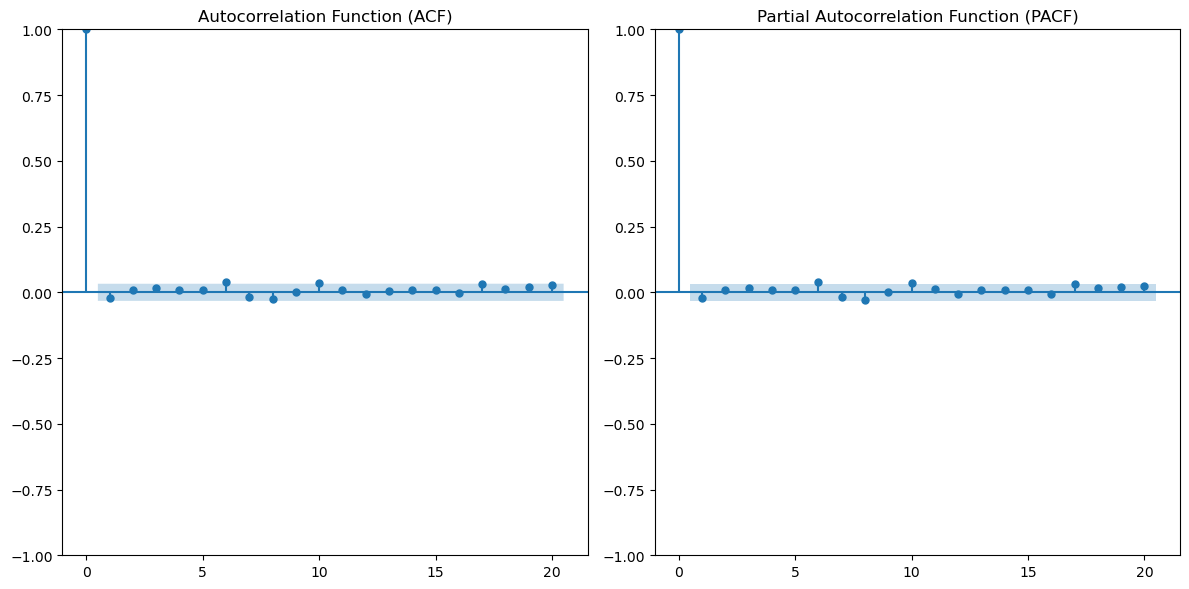

In [36]:
# Specify lag features of a time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(121)
plot_acf(df['Targets'].dropna(), lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# PACF plot
plt.subplot(122)
plot_pacf(df['Targets'].dropna(), lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

Both the graphs indicate no correlation of the target value with any of its lag features

In [3]:
# Finding the effect between the target with the Open, High, Low, Close, and Volume of the previous day.
from sklearn.feature_selection import mutual_info_regression
# Computing Bid-Ask spread as a feature
df['BAS']=2*(df['High']-df['Low'])/(df['High']+df['Low'])
# Computing moving average feature
df['MA_7']= (df['Targets'].rolling(window=7).sum())/7
df['MA_7']=df['MA_7'].shift(1)
#Computing standard deviation of return 
df['std_7']=df['Targets'].rolling(window=7).std()
df['std_7']=df['std_7'].shift(1)
df=df.dropna()
feature = df.drop(columns=['Targets'])
mi_score = pd.Series(mutual_info_regression(feature, df['Targets']), name="MI Scores", index=feature.columns)
mi_score

Open      0.010941
High      0.021160
Low       0.017375
Close     0.038337
Volume    0.022512
BAS       0.043918
MA_7      0.032192
std_7     0.068767
Name: MI Scores, dtype: float64

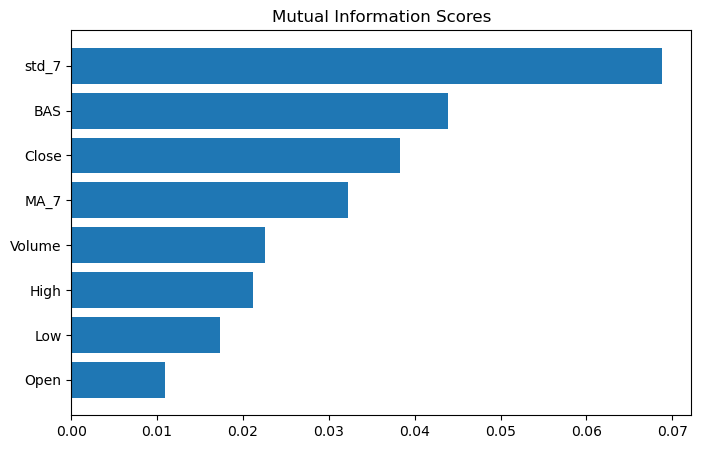

In [4]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_score)

**BAS** and **Close** are the most informative features for predicting rate of change based on MI score<br>
Dropping **Open**, **Low**, and **High** to prevent multicollinearity

In [5]:
df.drop(columns=['Open', 'Low', 'High'], inplace=True)
df

C:\Users\HAI\AppData\Local\Temp\ipykernel_54516\257673343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Open', 'Low', 'High'], inplace=True)


,Targets,Close,Volume,BAS,MA_7,std_7
Date,,,,,,
2014-09-25 00:00:00+00:00,-0.027483,423.204987,3.062770e+07,0.034949,-0.009653,0.056546
2014-09-26 00:00:00+00:00,-0.017370,411.574005,2.681440e+07,0.033739,-0.003304,0.050568
2014-09-27 00:00:00+00:00,-0.012128,404.424988,2.146080e+07,0.036638,0.004192,0.042269
2014-09-28 00:00:00+00:00,-0.055915,399.519989,1.502930e+07,0.023013,-0.002646,0.040133
2014-09-29 00:00:00+00:00,-0.004544,377.181000,2.361330e+07,0.068834,-0.007111,0.044492
...,...,...,...,...,...,...
2024-08-22 00:00:00+00:00,-0.012967,61175.191406,3.273115e+10,0.049908,0.006023,0.021483
2024-08-23 00:00:00+00:00,0.061483,60381.914062,2.762573e+10,0.026280,0.007034,0.020180
2024-08-24 00:00:00+00:00,0.001321,64094.355469,4.253051e+10,0.073014,0.012506,0.028688


## Outlier detection

<Axes: title={'center': 'Line chart of target variable'}, xlabel='Date'>

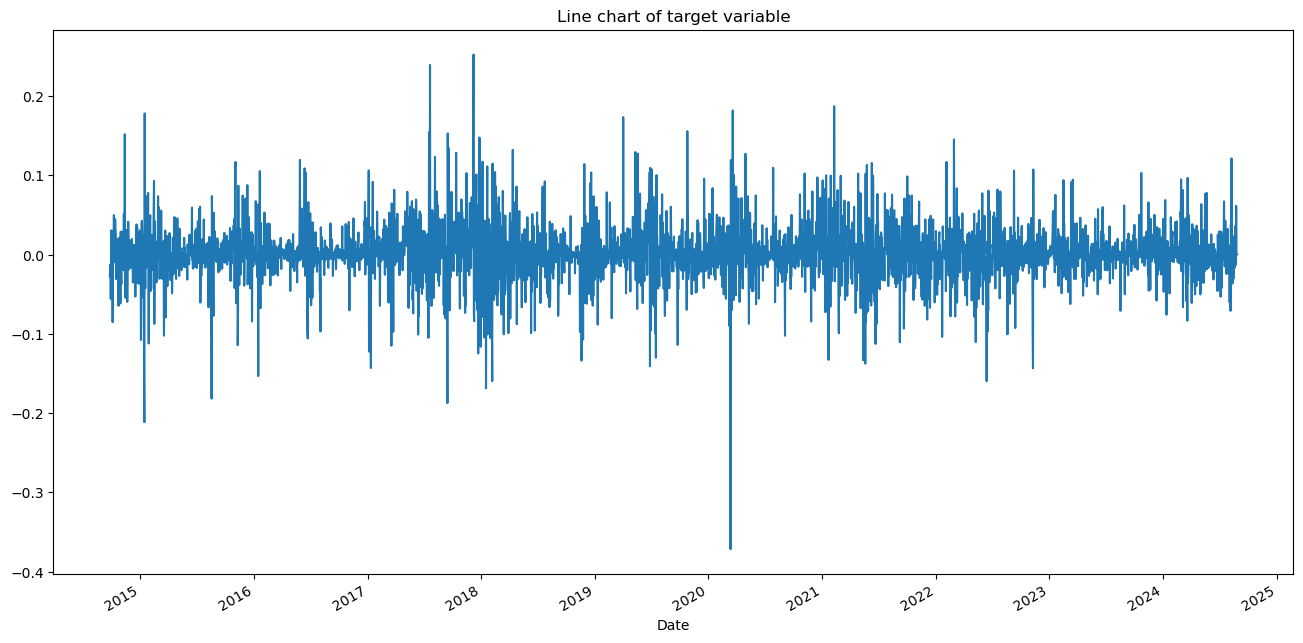

In [40]:
# VIsualizing target variable to eliminate outlier
df['Targets'].plot(figsize=(16,8), title='Line chart of target variable')

In [41]:
#Finding the outlier value
df['Targets'].describe()

count    3623.000000
mean        0.002058
std         0.036493
min        -0.371695
25%        -0.012599
50%         0.001320
75%         0.017042
max         0.252472
Name: Targets, dtype: float64

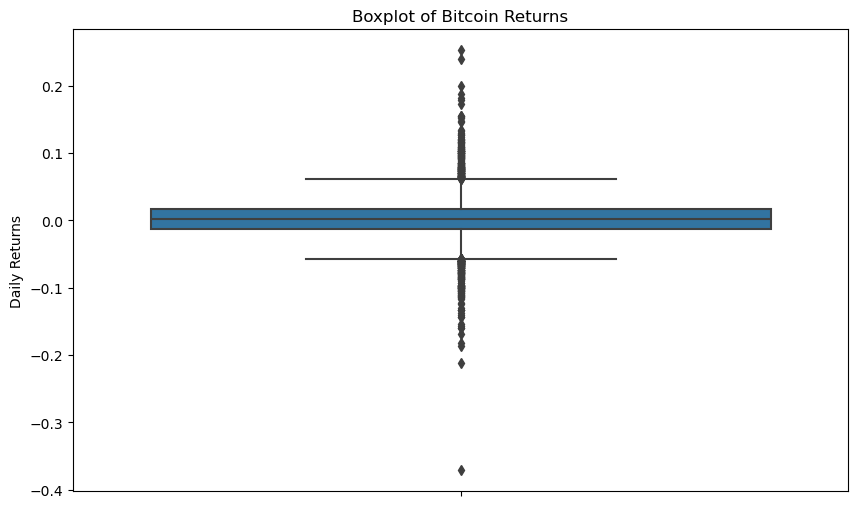

In [42]:
# Boxplot of Bitcoin return
import seaborn as sns
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(y=df['Targets'])

# Set the title and labels (optional)
plt.title('Boxplot of Bitcoin Returns')
plt.ylabel('Daily Returns')

# Show the plot
plt.show()

In [6]:
#Replacing the outlier with mean value
mean_return = df['Targets'].mean()

# Find the index of the minimum value in the return series
min_index = df['Targets'].idxmin()

# Replace the minimum value with the mean value
df.at[min_index, 'Targets'] = mean_return
df[df['Targets']==df['Targets'].min()]

,Targets,Close,Volume,BAS,MA_7,std_7
Date,,,,,,
2015-01-14 00:00:00+00:00,-0.211449,225.860992,72843904.0,0.198167,-0.031358,0.063931


<Axes: title={'center': 'Line chart of target variable'}, xlabel='Date'>

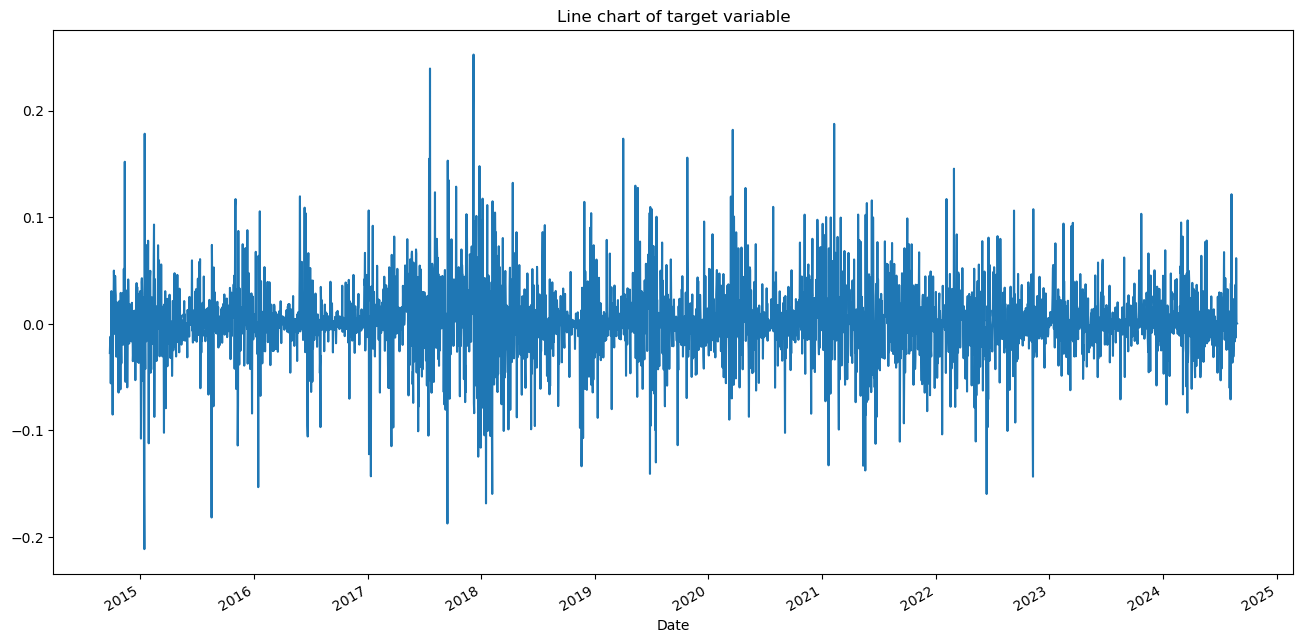

In [44]:
#Return time series line chart without outlier
df['Targets'].plot(figsize=(16,8), title='Line chart of target variable')

In [7]:
df

,Targets,Close,Volume,BAS,MA_7,std_7
Date,,,,,,
2014-09-25 00:00:00+00:00,-0.027483,423.204987,3.062770e+07,0.034949,-0.009653,0.056546
2014-09-26 00:00:00+00:00,-0.017370,411.574005,2.681440e+07,0.033739,-0.003304,0.050568
2014-09-27 00:00:00+00:00,-0.012128,404.424988,2.146080e+07,0.036638,0.004192,0.042269
2014-09-28 00:00:00+00:00,-0.055915,399.519989,1.502930e+07,0.023013,-0.002646,0.040133
2014-09-29 00:00:00+00:00,-0.004544,377.181000,2.361330e+07,0.068834,-0.007111,0.044492
...,...,...,...,...,...,...
2024-08-22 00:00:00+00:00,-0.012967,61175.191406,3.273115e+10,0.049908,0.006023,0.021483
2024-08-23 00:00:00+00:00,0.061483,60381.914062,2.762573e+10,0.026280,0.007034,0.020180
2024-08-24 00:00:00+00:00,0.001321,64094.355469,4.253051e+10,0.073014,0.012506,0.028688


# Building XGBoost model

## Train, Test split

In [8]:
train_data, test_data = np.split(df, [int(0.8*len(df))])
print(train_data.shape, test_data.shape)

(2899, 6) (725, 6)


c:\Users\HAI\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [9]:
y_train = train_data.pop('Targets')
X_train = train_data
y_valid = test_data.pop('Targets')
X_valid = test_data


## Training XGBoost

In [20]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
#Setting parameters
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,early_stopping_rounds=5, random_state=0)
#Training
model.fit(X_train, y_train,  eval_set=[(X_valid, y_valid)],verbose =2)


[0]	validation_0-rmse:0.02620


[2]	validation_0-rmse:0.02622
[4]	validation_0-rmse:0.02626


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

## Calculating loss on train and validation set

In [47]:
import math
# Root mean square error on validation set
predictions = model.predict(X_valid)
print("Root mean squared error: " + str(math.sqrt(mean_squared_error(predictions, y_valid))))

Root mean squared error: 0.02620191031553212


In [ ]:
#Calculating error of moving average model on validation set
rmse = math.sqrt(mean_squared_error(X_valid['MA_7'], y_valid))
print("Root mean squared error of moving average model: " + str(rmse))

In [52]:
#Root mean square error on train set
insample_prediction = model.predict(X_train)
print("Root mean squared error: " + str(math.sqrt(mean_squared_error(insample_prediction, y_train))))

Root mean squared error: 0.03789422197938028


## Visualizing insample prediction

In [51]:
#Visualize insample prediction (train_set)
insample_prediction = pd.DataFrame(insample_prediction, index=train_data.index)
insample_prediction.rename(columns={0:"prediction"}, inplace=True)
fig = px.line(insample_prediction,y=insample_prediction.columns, title='Insample prediction (Train set)')
fig.show()

c:\Users\HAI\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [50]:
#Visualize insample prediction (validation_set)
predictions = pd.DataFrame(predictions, index=test_data.index)
predictions.rename(columns={0:"prediction"}, inplace=True)
fig = px.line(predictions,y=predictions.columns, title='Insample prediction (Validation set)')
fig.show()

c:\Users\HAI\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



## Save the trained model

In [53]:
import joblib
joblib.dump(model, 'model.joblib')


['model.joblib']